In [1]:
import numpy as np
import pandas as pd
import bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
%matplotlib inline

Loading BokehJS ...

David Diaz  
SEFS 590F (Bayesian Models) - Winter 2016-17

## Mid-term Exam

### A. Consider the model,  
$\frac{1}{N}\frac{dN}{dt}=r-\frac{r}{K}N$  

### which is a linear model with intercept $r$ and slope $\frac{r}{K}$. Note that these quantities have a biological interpretation in population ecology; $r$ is the intrinsic rate of increase, $\frac{r}{K}$ is the strength of the feedback from population size to population growth rate, and $K$ is the carrying capacity at which $\frac{dN}{dt}=0$. You have a data set consisting of 100 observations of per capita rate of growth paired with observations of $N$ for manatees. The vector $\mathbf y$ contains values for the rate and the vector $\mathbf N$ contains aligned data on $N$, i.e., $y_i=\frac{1}{N_i}\frac{dN_i}{dt}$. Therefore, we can describe the model such that:  

$y_i\sim Normal(\mu_i,\sigma^2)$  
$\mu_i=r-\frac{r}{K}N_i$

#### 1. Using the data provided in “manatee.csv”, write an optimization algorithm or use the ```nls``` function to find the estimated values of $r$, $K$, $\sigma^2$. What is the expected carrying capacity of this species and the intrinsic growth rate?

In [2]:
from scipy.optimize import leastsq

In [3]:
# create the deterministic model
def growth(params, N_i):
    '''
    Deterministic model that calculates per capita growth rate with the form
    mu_i = r - r/K*N_i
    where:
    mu_i = per capita growth rate of sample i
    r = instrinsic rate of increase
    K = carrying capacity at which population growth is zero
    N_i = number of individuals in sample i
    '''
    r, K = params
    growth_rate = r - r/K*N_i
    return growth_rate

In [4]:
def residuals(params, y, x): # the function we'll seek to 
    return y - growth(params, x) # minimize using leastsq

In [5]:
df = pd.read_csv('manatee.csv') # read in the dataset
x, y = df.N, df.y
x0 = [0.5, 70] # starting estimates of parameter values r and K

In [6]:
# fit the leastsq model
results, flag = leastsq(func=residuals, x0=x0, args=(y, x))
print("intrinsic growth rate, r: ", results[0])
print("carrying capacity, K: ", results[1])

intrinsic growth rate, r:  0.993938758023
carrying capacity, K:  103.737360134


#### 2. Plot the data and the mean predicted values based on your parameter estimates from part 1.

In [7]:
# plot the data
p = figure(title="Population Growth", x_axis_label='Population Size', 
           y_axis_label='Annual Growth Rate (per capita)')
xs = np.arange(0, 105, 1)
p.line(xs, growth(results, xs), line_width=4, 
         alpha=0.5, color='blue', legend='Predicted')
p.circle(x, y, size=8, 
         alpha=0.6, color='orange', legend='Observed')
show(p)

#### 3. Write a DAG for the model. Determine which parameters require priors and identify vague priors for those parameters that need priors. Write out the full joint distribution for the model (I’m looking for more than just the notation of say $[p\mid y]\propto[y\mid p][p]$).

In [8]:
import daft # for drawing a DAG

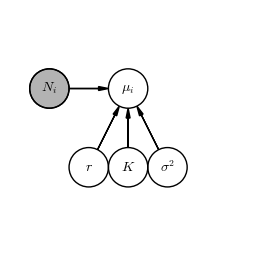

In [9]:
# instantiate the DAG using the daft package
dag = daft.PGM([3, 3], origin=[0, 0]) 
# create nodes in DAG
dag.add_node(daft.Node('mu_i', r'$\mu_i$', 1.5, 2.0))
dag.add_node(daft.Node('r', r'$r$', 1.0, 1.0))
dag.add_node(daft.Node('K', r'$K$', 1.5, 1.0))
dag.add_node(daft.Node('sigma2', r'$\sigma^2$', 2.0, 1.0))
dag.add_node(daft.Node('N_i', r'$N_i$', 0.5, 2.0, observed=True))
#add edges
dag.add_edge('r', 'mu_i')
dag.add_edge('K', 'mu_i')
dag.add_edge('sigma2', 'mu_i')
dag.add_edge('N_i', 'mu_i')

dag.render()

Parameters which require priors: $r$, $K$, and $\sigma^2$.

Vague priors for these parameters:  
$r\sim gamma(\alpha_r = 0.001, \beta_r= 0.001)$  
$K\sim gamma(\alpha_K = 0.001, \beta_K= 0.001)$  
$\sigma^2\sim gamma(\alpha_{\sigma^2} = 0.001, \beta_{\sigma^2}= 0.001)$

Joint Distribution:  
$[r,K,\sigma^2\mid\mu_i] \propto [\mu_i\mid r,K,\sigma^2][r][K][\sigma^2]$  
$[r,K,\sigma^2\mid\mu_i] \propto \prod_{i=1}^N normal(r,K,\sigma^2)\cdot gamma(\alpha_r,\beta_r)\cdot gamma(\alpha_K,\beta_K)\cdot gamma(\alpha_{\sigma^2}, \beta_{\sigma^2})$

#### 4. Write your own Metropolis or Metropolis-Hastings samplers for this model (we will cover Gibbs sampling soon in class, but do not use Gibbs). For this part of the question, set $K=100$. Please write out your priors and proposal distributions so I can easily see them.

In [10]:
from scipy.stats import norm, gamma, invgamma

K = 100 # fixed for this question

def L(r, sigma): # function to calculate likelihood of data given parameters
    pred = growth(params=[r,K], N_i=df.N) # calculate estimated growth rates
    return np.prod(norm.pdf(x=df.y, loc=pred, scale=sigma)) # return product of likelihoods

def pr(theta, alpha, beta): # calculate the probability of a gamma prior
    return gamma.pdf(x=theta, a=alpha, scale=1/beta)

In [22]:
num_links = 5000 # number of "links" or samples in a chain

# vague prior from earlier run
# alpha_r, beta_r = 0.001, 0.001
# alpha_sig, beta_sig = 0.001, 0.001

# an informative prior
mu_alpha, sigma_alpha = 0.5, 0.01
alpha_r, beta_r = mu_alpha**2/sigma_alpha**2, mu_alpha/sigma_alpha**2
mu_sigma, sigma_sigma = 0.3, 0.01
alpha_sig, beta_sig = mu_sigma**2/sigma_sigma**2, mu_sigma/sigma_sigma**2

# set tuning parameters (Standard Deviation)
# for drawing proposals from a normal distribution
r_tune = 0.1
sigma_tune = 0.05

In [25]:
# markov chain monte carlo using metropolis sampler

# create chains
r_chain = np.empty(num_links)
sigma_chain = np.empty(num_links)

# Set initial values in chains
r_chain[0] = 1
sigma_chain[0] = 0.5

# track the acceptance rate
r_accepted, sigma_accepted = 0, 0 

for i in range(1, num_links):
    
    # work on parameter r
    r_prop = np.random.normal(loc=r_chain[i-1], scale=r_tune) # draw a new proposal 
    # calculate metropolis ratio using existing sigma estimate
    r_numer = L(r_prop, sigma_chain[i-1]) * pr(r_prop, alpha_r, beta_r)
    r_denom = L(r_chain[i-1], sigma_chain[i-1]) * pr(r_chain[i-1], alpha_r, beta_r)
    r_ratio = r_numer/r_denom
    if r_ratio > np.random.uniform(low=0, high=1): # decision probability
        r_chain[i] = r_prop # accept the proposal
        r_accepted += 1 # track the acceptance
    else:
        r_chain[i] = r_chain[i-1] # reject the proposal

    # work on parameter sigma
    sigma_prop = np.random.normal(loc=sigma_chain[i-1], scale=sigma_tune) # draw a new proposal
    # calculate metropolis ratio using updated r parameter
    s_numer = L(r_chain[i], sigma_prop) * pr(sigma_prop, alpha_sig, beta_sig)
    s_denom = L(r_chain[i], sigma_chain[i-1]) * pr(sigma_chain[i-1], alpha_sig, beta_sig)
    s_ratio = s_numer/s_denom
    
    if s_ratio > np.random.uniform(low=0, high=1): # decision probability
        sigma_chain[i] = sigma_prop
        sigma_accepted += 1
    else:
        sigma_chain[i] = sigma_chain[i-1]
        
print("r acceptance rate: ", r_accepted/num_links)
print("Sigma acceptance rate: ", sigma_accepted/num_links)

# create interactive plots using bokeh
# subplot 1: r parameter trace
s1 = figure(title="Trace of r parameter from second simulation", 
            x_axis_label='iterations', y_axis_label='value of r',
            width=200, plot_height=200)
s1.line(range(num_links), r_chain, line_width=2)
#subplot 2: histogram of r parameter trace
s2 = figure(title="Histogram of r parameter trace",
            x_axis_label='value of r', y_axis_label='iterations',
            width=200, plot_height=200)
hist_r, edges_r = np.histogram(r_chain[100:], density=True, bins=50)
s2.quad(top=hist_r, bottom=0, left=edges_r[:-1], right=edges_r[1:], line_color='black')

# subbplot 3: sigma parameter trace
s3 = figure(title="Trace of sigma parameter from second simulation",
            x_axis_label='iterations', y_axis_label='value of sigma',
            width=200, plot_height=200)
s3.line(range(num_links), sigma_chain, line_width=2)
#subplot 4: histogram of sigma parameter trace
s4 = figure(title="Trace of sigma parameter trace", 
            x_axis_label='value of sigma', y_axis_label='count',
            width=200, plot_height=200)
hist_s, edges_s = np.histogram(sigma_chain[100:], density=True, bins=50)
s4.quad(top=hist_s, bottom=0, left=edges_s[:-1], right=edges_s[1:], line_color='black')

p = bokeh.layouts.gridplot(children=[[s1,s2],[s3,s4]])
show(p)

r acceptance rate:  0.1286
Sigma acceptance rate:  0.2268


#### 5. Test the sensitivity of your priors by changing the parameters (do at least 2 different values for the priors) and fitting the model again. Compare the results and discuss if the priors affected the posterior estimates.

The graphs below show the results of the first simulation. The graphs above have been updated using different values for the priors.  These graphs are from the use of gamma priors for both $r$ and $\sigma$ of $gamma(0.001, 0.001)$. The graphs above show use of informative gamma priors of $r\sim gamma(\mu=0.5, \sigma=0.01)$ and $\sigma\sim gamma(\mu=0.3,\sigma=0.01)$. Updating the priors from vague to informative also resulted in non-convergence for several runs, so which was resolved by adjusting starting values for the chain.

In [21]:
r_chain1 = r_chain
s_chain1 = sigma_chain

# create interactive plots using bokeh
# subplot 1: r parameter trace
s1 = figure(title="Trace of r parameter from first simulation", 
            x_axis_label='iterations', y_axis_label='value of r',
            width=200, plot_height=200)
s1.line(range(num_links), r_chain1, line_width=2)
#subplot 2: histogram of r parameter trace
s2 = figure(title="Histogram of r parameter trace",
            x_axis_label='value of r', y_axis_label='iterations',
            width=200, plot_height=200)
hist_r, edges_r = np.histogram(r_chain1[100:], density=True, bins=50)
s2.quad(top=hist_r, bottom=0, left=edges_r[:-1], right=edges_r[1:], line_color='black')

# subbplot 3: sigma parameter trace
s3 = figure(title="Trace of sigma parameter from first simulation",
            x_axis_label='iterations', y_axis_label='value of sigma',
            width=200, plot_height=200)
s3.line(range(num_links), s_chain1, line_width=2)
#subplot 4: histogram of sigma parameter trace
s4 = figure(title="Histogram of sigma parameter trace", 
            x_axis_label='value of sigma', y_axis_label='count',
            width=200, plot_height=200)
hist_s, edges_s = np.histogram(s_chain1[100:], density=True, bins=50)
s4.quad(top=hist_s, bottom=0, left=edges_s[:-1], right=edges_s[1:], line_color='black')

p = bokeh.layouts.gridplot(children=[[s1,s2],[s3,s4]])
show(p)

As can be seen in the graphs further above compared to those immediately above, the use of informative priors shifted the posterior distribution estimated from the MCMC trace substantially towards the priors and further away from the likelihood estimates of the parameters.

### B. The dataset called “examdata.csv” is a set of 100 values. You are to determine the posterior distribution of the mean and the associated 95% credible interval. To do so, you will need to make a number of decisions and assumptions, be sure to state these in your answer. You will have to not only make assumptions about the data, but also determine an appropriate prior.

In [14]:
exams = pd.read_csv("examdata.csv")

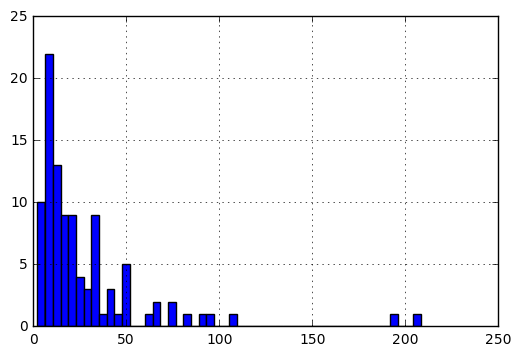

In [15]:
exams['x'].hist(bins=50)

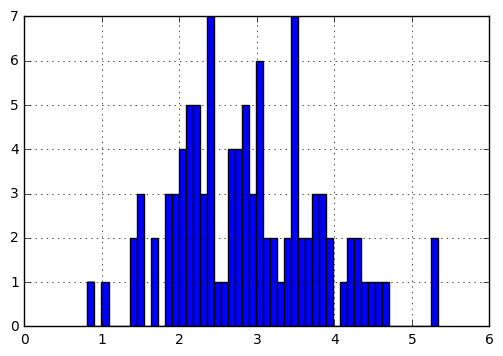

In [16]:
np.log(exams.x).hist(bins=50)

In [17]:
np.log(exams.x).describe()

count    100.000000
mean       2.876486
std        0.914467
min        0.813219
25%        2.179015
50%        2.813174
75%        3.501413
max        5.339693
Name: x, dtype: float64

Based on observations of continuous, exclusively positive data with log transformed values that appear to be normally distributed, $x$ will be modeled using a lognormal distribution, $x\sim lognormal(\alpha,\beta)$. Parameters $\alpha$ and $\beta$ will be modeled using vague priors $N(\mu=0, \sigma^2=1000)$.  

The posterior distribution is represented as:  
\begin{align}
\ [\alpha,\beta\mid x]&\propto[x\mid \alpha,\beta][\alpha][\beta]\\
\ &\propto lognormal(\alpha,\beta)\cdot N(0, 1000)\cdot N(0, 1000) \\
\end{align}

If we assume the standard deviation of this distribution is known (actually grabbed from the data), we can solve analytically for the posterior distribution for the mean using conjugate distributions.

In [18]:
mu = (0/1000+np.sum(np.log(exams.x)/1000))/(1/1000+100/0.914467)
sigma = (1/1000+100/0.914467)**(-1)

In [19]:
print("mean estimate of x (on log scale): ", mu)
print("95% credible interval: [",norm.ppf(0.025, loc=mu, scale=sigma),",",norm.ppf(0.975, loc=mu, scale=sigma),"]")

print("mean estimate of x (on real scale): ", np.exp(mu))
print("95% credible interval: [",np.exp(norm.ppf(0.025, loc=mu, scale=sigma)),",",np.exp(norm.ppf(0.975, loc=mu, scale=sigma)),"]")

mean estimate of x (on log scale):  0.0026304277205453416
95% credible interval: [ -0.0152926322295 , 0.0205534876706 ]
mean estimate of x (on real scale):  1.00263389033
95% credible interval: [ 0.984823706275 , 1.02076616519 ]


### C. Read the Ellison 2004 paper and answer the following questions:

#### 1. Ellison analyzes a dataset on ant species richness. Write down the full posterior distribution for the model described in eq. (3). Be sure to include the prior distributions (use those he describes as informative).

\begin{align}
\ log(\hat S_i) &= \hat\beta_0 + \hat\beta_1 latitude_i + \hat\beta_2 elevation_i + \hat\beta_3 habitat_i \\
log(\hat S_i) &\sim Poisson(\lambda) \\
\hat\beta_0 &\sim N(0, 1000) \\
\hat\beta_1 &\sim N(-0.017, 0.04) \\
\hat\beta_2 &\sim N(-0.002, 0.0003) \\
\hat\beta_3 &\sim N(-0.37, 1) \\
[\hat\beta_0, \hat\beta_1, \hat\beta_2, \hat\beta_3 \mid \hat S_i] &\propto \prod_{i=1}^N[\hat S_i \mid \hat\beta_0, \hat\beta_1, \hat\beta_2, \hat\beta_3][\hat\beta_0][\hat\beta_1][\hat\beta_2][\hat\beta_3] \\ 
&\propto Poisson(\hat\beta_0, \hat\beta_1, \hat\beta_2, \hat\beta_3) \cdot N(0, 1000) \cdot N(-0.017, 0.04) \cdot N(-0.002, 0.0003) \cdot N(-0.37, 1) \\
\end{align}

#### 2. Discuss briefly if you think how he derived his informative priors is valid (think ecologically and statistically).

For full disclosure, my first ecological research experience was working for the author, Aaron Ellison, at Harvard Forest on ant survey work as an undergraduate. 

Ellison selected priors from earlier peer-reviewed publications of ant species richness in a variety of places around the world. The judgement of the validity of these priors can be made based on the scale or nature of inference intended. The priors selected utilize the same predictor variables (elevation, latitude, habitat openness) as well. This seems to be a reasonable selection of priors to make inference about whether the distribution of ant species in Ellison's study region are consistent with those relationships observed globally. If he desires to identify finer-scale drivers within the region, it would be preferable to utilize datasets generated from more closely related geographic and ecological contexts to offer more informative priors.

#### 3. Summarize briefly how Ellison suggests one should decide on using a Bayesian versus frequentist approach.

Fundamentally, Ellison argues the choice is related to the epistemological or underlying theory and approach to modeling that the ecologist believes is most appropriate. Bayesian methods are recommended when model parameters are conceptually accepted as random variables, and when the use of prior knowledge is desired. Consideration of replicability is mentioned, but not a clear deciding factor. Similarly, the author describes the depth of scientific knowledge and discussion on the applications of the method(s) chosen (e.g., model-selection, model averaging) as an important consideration for whether or not a particular application of Bayesian or frequentist methods will be well-founded.